# Calvert County, MD Investigation

In order to see what kinds of post-solution analyses would be useful/interesting for the Beta release, this notebook looks at results of finding optimal solutions to the NLP for Calvert county.

We will combine the results from both cost-minimization-objective and load-maximization-objective, look at the results' curves, and then plot the results on a map.

### Data Sources
- P6Beta_v3_LRSegs_081516_Albers.shp: a shapefile with land-river-segment geographies throughout the Bay watershed (*Gopal shared this with me via email on 2018/12/11*)
- calvertMD_solutionlist_20181210.txt: a list of optimization solution .csv files to read (*generated these results myself on Cloudfish on 2018/12/10*) 

### Changes
- 2018/12/23: Started documenting this notebook

### Table of Contents
1. [Load Data](#load_data)
    1. [load shapefile](#load_shapefile)
    2. [load solution data](#load_solution_data)
2. [Make Solution "Objective-Constraint" Figures](#make_solution_objective-constraint_figures)
3. [Merge Geo data with Solution data](#merge_geo_data_with_solution_data)
4. [Prepare data for solution "Variable-Values" visualizations](#prepare_data_for_solution_variable-values_visualizations)
    1. [Get data for a single constraint level](#get_data_for_a_single_constraint_level)
    2. [Get data for a single BMP](#get_data_for_a_single_bmp)
5. [Map the results](#map_the_results)

In [1]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns

import re

import matplotlib.pyplot as plt
import matplotlib.cm

import geopandas as gpd

<a id='load_data'></a>
# 1. Load Data

<a id='load_shapefile'></a>
### 1a. load shapefile

In [81]:
# mdshapefiledir= '/Users/Danny/Desktop/CATEGORIES/CAREER_MANAGEMENT/CRC_ResearchScientist_Optimization/Optimization_Tool/2_ExperimentFolder/bayota/bin/shapefiles/Maryland_Physical_Boundaries__County_Boundaries_Detailed'
# fp = os.path.join(mdshapefiledir, 'Maryland_Physical_Boundaries__County_Boundaries_Detailed.shp')

lrsegshapefiledir = '/Users/Danny/Desktop/CATEGORIES/CAREER_MANAGEMENT/CRC_ResearchScientist_Optimization/Optimization_Tool/2_ExperimentFolder/bayota/bin/shapefiles/P6Beta_v3_LRSegs_081516_Albers'
fp = os.path.join(lrsegshapefiledir, 'P6Beta_v3_LRSegs_081516_Albers.shp')

map_df = gpd.read_file(fp)

display(map_df.head(2))

,Major,Minor,UniqID,DSID,Flow,RiverSeg,TidalWater,MajMin,Region,Watershed,...,ST,CNTYNAME,CBW,FIPS_NHL,PRECIP,MEANPRECIP,LndRvrSeg,Acres,HGMR,geometry
0,Z,Z,9999,9999,0,ZZ0_9999_9999,N,ZZ,Regions Outside of Chesapeake Bay Watershed,Land Segment Only-No River Simulation,...,NY,ALLEGANY,N,N36003,N,1021,N36003ZZ0_9999_9999,608092.605660,None,"POLYGON ((1457905.657400004 2307419.286199999,..."
1,Z,Z,9999,9999,0,ZZ0_9999_9999,N,ZZ,Regions Outside of Chesapeake Bay Watershed,Land Segment Only-No River Simulation,...,NY,BROOME,N,N36007,N,1055,N36007ZZ0_9999_9999,51399.259219,None,"POLYGON ((1675276.761900002 2314848.455699998,..."


In [ ]:
# map_df.plot()

<a id='load_solution_data'></a>
### 1b. Load solution data

In [3]:
output_dir = '/Users/Danny/bayota_ws_0.0.1/output/general/solutions_calvertMD_cost_and_load_20181210'
namelistfile = 'calvertMD_solutionlist_20181210.txt'
filelist = os.path.join(output_dir, namelistfile)

with open(os.path.join(output_dir, namelistfile)) as f:
    content = f.readlines()
filelist = [os.path.join(output_dir, x.strip()) for x in content]

In [82]:
# Add a column with file names
dlist = []
for f in filelist:
    tmpdf = pd.read_csv(f)
    tmpdf['solutionname'] = os.path.basename(f)

    #     (pd.DataFrame.assign)(df, solutionname=os.path.basename(filename))

    dlist.append(tmpdf)
df = pd.concat(dlist, ignore_index=True)
display(df.head(2))

df = df.loc[df['acres'] >= 0.5, :]

# Add a column with unique variable (x) names
df['x'] = list(zip(df.bmpshortname,
                   df.landriversegment,
                   df.loadsource,
                   df.totalannualizedcostperunit))

df = df.reset_index()
display(df.head(2))

/Users/Danny/anaconda3/envs/bayota36/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.


,Unnamed: 0,acres,bmpshortname,feasible,landriversegment,loadsource,percent_reduction_minimum,solution_objective,solutionname,totalannualizedcostperunit,totalcostupperbound,totalinstancecost
0,0,43.877017,LowResTill,True,N24009XL0_5346_0000,dbl,1.0,0.000021,solutiondf_modelinstance_costmin_total_percent...,0.0,NaN,0.0
1,1,22.780089,LowResTill,True,N24009XL0_5346_0000,oac,1.0,0.000021,solutiondf_modelinstance_costmin_total_percent...,0.0,NaN,0.0


,index,Unnamed: 0,acres,bmpshortname,feasible,landriversegment,loadsource,percent_reduction_minimum,solution_objective,solutionname,totalannualizedcostperunit,totalcostupperbound,totalinstancecost,x
0,0,0,43.877017,LowResTill,True,N24009XL0_5346_0000,dbl,1.0,0.000021,solutiondf_modelinstance_costmin_total_percent...,0.0,NaN,0.0,"(LowResTill, N24009XL0_5346_0000, dbl, 0.0)"
1,1,1,22.780089,LowResTill,True,N24009XL0_5346_0000,oac,1.0,0.000021,solutiondf_modelinstance_costmin_total_percent...,0.0,NaN,0.0,"(LowResTill, N24009XL0_5346_0000, oac, 0.0)"


In [83]:
df['objective_cost'] = df['solution_objective']
df['objective_loadreduction'] = df['solution_objective']

df.loc[np.isnan(df.totalcostupperbound), 'objective_loadreduction'] = np.nan
df.loc[np.isnan(df.percent_reduction_minimum), 'objective_cost'] = np.nan
display(df.head(2))
display(df.tail(2))

,index,Unnamed: 0,acres,bmpshortname,feasible,landriversegment,loadsource,percent_reduction_minimum,solution_objective,solutionname,totalannualizedcostperunit,totalcostupperbound,totalinstancecost,x,objective_cost,objective_loadreduction
0,0,0,43.877017,LowResTill,True,N24009XL0_5346_0000,dbl,1.0,0.000021,solutiondf_modelinstance_costmin_total_percent...,0.0,NaN,0.0,"(LowResTill, N24009XL0_5346_0000, dbl, 0.0)",0.000021,NaN
1,1,1,22.780089,LowResTill,True,N24009XL0_5346_0000,oac,1.0,0.000021,solutiondf_modelinstance_costmin_total_percent...,0.0,NaN,0.0,"(LowResTill, N24009XL0_5346_0000, oac, 0.0)",0.000021,NaN


,index,Unnamed: 0,acres,bmpshortname,feasible,landriversegment,loadsource,percent_reduction_minimum,solution_objective,solutionname,totalannualizedcostperunit,totalcostupperbound,totalinstancecost,x,objective_cost,objective_loadreduction
42197,714503,11683,1.387189,HRTill,True,N24009WL0_4925_0000,gwm,NaN,36.704547,solutiondf_modelinstance_loadreductionmax_Calv...,0.0,4000000.0,0.0,"(HRTill, N24009WL0_4925_0000, gwm, 0.0)",NaN,36.704547
42198,714504,11684,0.843612,HRTill,True,N24009WL0_4925_0000,soy,NaN,36.704547,solutiondf_modelinstance_loadreductionmax_Calv...,0.0,4000000.0,0.0,"(HRTill, N24009WL0_4925_0000, soy, 0.0)",NaN,36.704547


In [85]:
# Keep one row for each optimization trial, since we're just looking at objective and constraint values (rather than variable values)
df_single_row_for_each_solution = df.drop_duplicates(subset=['solutionname'])
display(df_single_row_for_each_solution.head(2))

,index,Unnamed: 0,acres,bmpshortname,feasible,landriversegment,loadsource,percent_reduction_minimum,solution_objective,solutionname,totalannualizedcostperunit,totalcostupperbound,totalinstancecost,x,objective_cost,objective_loadreduction
0,0,0,43.877017,LowResTill,True,N24009XL0_5346_0000,dbl,1.0,0.000021,solutiondf_modelinstance_costmin_total_percent...,0.0,NaN,0.0,"(LowResTill, N24009XL0_5346_0000, dbl, 0.0)",0.000021,NaN
576,791,3,0.633319,LowResTill,True,N24009WL0_4923_0000,gwm,2.0,0.000142,solutiondf_modelinstance_costmin_total_percent...,0.0,NaN,0.0,"(LowResTill, N24009WL0_4923_0000, gwm, 0.0)",0.000142,NaN


<a id='make_solution_objective-constraint_figures'></a>
# 2. Make Solution "Objective-Constraint" Figures

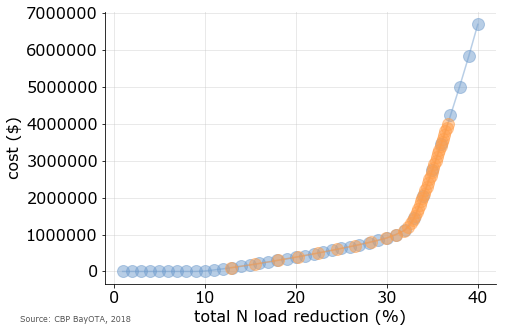

In [7]:
# from bayota_settings.config_script import get_graphics_dir
from matplotlib import rcParams

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['MS Reference Sans Serif']
rcParams['font.weight'] = 'normal'
rcParams['font.size'] = 16

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(7, 5))

# ------- Plot 1 -------
# set a variable that will call whatever column we want to visualise on the map
xvar = 'percent_reduction_minimum'
yvar = 'objective_cost'
ax.plot(df_single_row_for_each_solution[xvar], df_single_row_for_each_solution[yvar],
        color=[114/255, 158/255, 206/255],
        linestyle='-',
        markersize=12,
        marker='o',
        alpha=0.5)

# ------- Plot 2 -------
# set a variable that will call whatever column we want to visualise on the map
xvar = 'objective_loadreduction'
yvar = 'totalcostupperbound'
ax.plot(df_single_row_for_each_solution[xvar], df_single_row_for_each_solution[yvar],
        #color=[255/255, 127/255, 14/255],
        color=[255/255, 158/255, 74/255],
        linestyle='-',
        markersize=12,
        marker='o',
        alpha=0.5)

ax.grid(color=[200/255, 200/255, 200/255],
            alpha=0.4, linestyle='-', linewidth=1)

# Hide the right and top spines
ax.spines['top'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(False)

ax.set_xlabel('total N load reduction (%)')
ax.set_ylabel('cost ($)')

# add a title
ax.set_title('', fontdict={'fontsize': '14', 'fontweight' : '3'})

# create an annotation for the data source
ax.annotate("Source: CBP BayOTA, 2018",
            xy=(0.04, .05), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=8, color='#555555')

# Save the graphic
fig.savefig("pareto_calvertMD_20181210.png",
            bbox_inches='tight', dpi=300)
# fig.savefig(os.path.join(get_graphics_dir(), "map_export_new.png"),
#             bbox_inches='tight', dpi=300)

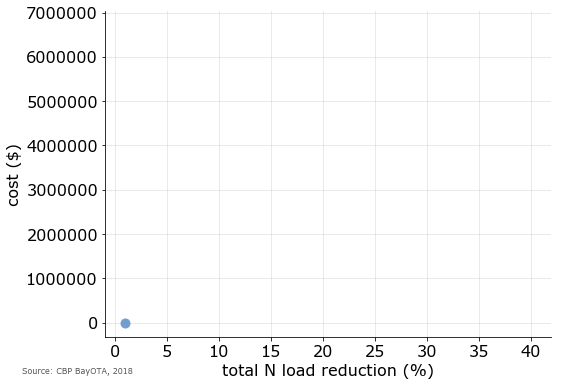

In [8]:
# from bayota_settings.config_script import get_graphics_dir
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['MS Reference Sans Serif']
rcParams['font.weight'] = 'normal'
rcParams['font.size'] = 16

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(8, 6))

# ------- Plot 1 -------
# set a variable that will call whatever column we want to visualise on the map
xvar = 'percent_reduction_minimum'
yvar = 'objective_cost'
ax.plot(#df_single_row_for_each_solution[xvar], df_single_row_for_each_solution[yvar],
        df_single_row_for_each_solution.loc[df_single_row_for_each_solution[xvar]==1,:][xvar], 
        df_single_row_for_each_solution.loc[df_single_row_for_each_solution[xvar]==1,:][yvar],
        color=[114/255, 158/255, 206/255],
        linestyle='-',
        markersize=9,
        marker='o')

ax.set_xlim(-0.9500000000000002, 41.95)
ax.set_ylim(-334831.9665814999, 7031471.298664903)

# print(ax.get_xlim())
# print(ax.get_ylim())

ax.grid(color=[200/255, 200/255, 200/255],
            alpha=0.4, linestyle='-', linewidth=1)

# Hide the right and top spines
ax.spines['top'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(False)

ax.set_xlabel('total N load reduction (%)')
ax.set_ylabel('cost ($)')
ax.set_title('', fontdict={'fontsize': '14', 'fontweight' : '3'})

# create an annotation for the data source
ax.annotate("Source: CBP BayOTA, 2018",
            xy=(0.04, .05), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=8, color='#555555')

# Save the graphic
fig.savefig("costvsload_calvertMD_1pt_20181210.png",
            bbox_inches='tight', dpi=300)
# fig.savefig(os.path.join(get_graphics_dir(), "map_export_new.png"),
#             bbox_inches='tight', dpi=300)

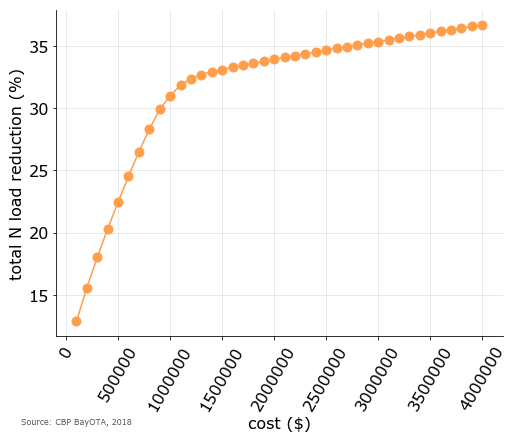

In [9]:
# from bayota_settings.config_script import get_graphics_dir
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['MS Reference Sans Serif']
rcParams['font.weight'] = 'normal'
rcParams['font.size'] = 16

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(8, 6))

# ------- Plot 2 -------
# set a variable that will call whatever column we want to visualise on the map
xvar = 'totalcostupperbound'
yvar = 'objective_loadreduction'
ax.plot(df_single_row_for_each_solution[xvar], df_single_row_for_each_solution[yvar],
        color=[255/255, 158/255, 74/255],
        linestyle='-',
        markersize=9,
        marker='o')

ax.grid(color=[200/255, 200/255, 200/255],
            alpha=0.4, linestyle='-', linewidth=1)

# Hide the right and top spines
ax.spines['top'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(False)

plt.xticks(rotation=60)
ax.set_xlabel('cost ($)')
ax.set_ylabel('total N load reduction (%)')
ax.set_title('', fontdict={'fontsize': '14', 'fontweight' : '3'})

# create an annotation for the data source
ax.annotate("Source: CBP BayOTA, 2018",
            xy=(0.04, .05), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=8, color='#555555')

# Save the graphic
fig.savefig("loadvscost_calvertMD_20181210.png",
            bbox_inches='tight', dpi=300)
# fig.savefig(os.path.join(get_graphics_dir(), "map_export_new.png"),
#             bbox_inches='tight', dpi=300)

<a id='merge_geo_data_with_solution_data'></a>
# 3. Merge Geo data with Solution data

In [55]:
# merged = map_df.set_index('LndRvrSeg').join(df.set_index('landriversegment'))
merged = map_df.set_index('LndRvrSeg').join(df.set_index('landriversegment'))
display(merged.shape)
display(merged.head(2))
# merged.drop(merged.get_level_value(0).isin(df['landriversegment']))
merged = merged[merged.index.isin(df['landriversegment'])]
display(merged.head(2))
display(merged.shape)

(44238, 40)

,Major,Minor,UniqID,DSID,Flow,RiverSeg,TidalWater,MajMin,Region,Watershed,...,loadsource,percent_reduction_minimum,solution_objective,solutionname,totalannualizedcostperunit,totalcostupperbound,totalinstancecost,x,objective_cost,objective_loadreduction
H24021PM1_3510_4000,P,M,3510,4000,1,PM1_3510_4000,N,PM,Chesapeake Bay Watershed,Potomac River Basin,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
H24021PM3_3040_3340,P,M,3040,3340,3,PM3_3040_3340,N,PM,Chesapeake Bay Watershed,Potomac River Basin,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,Major,Minor,UniqID,DSID,Flow,RiverSeg,TidalWater,MajMin,Region,Watershed,...,loadsource,percent_reduction_minimum,solution_objective,solutionname,totalannualizedcostperunit,totalcostupperbound,totalinstancecost,x,objective_cost,objective_loadreduction
N24009WL0_4772_0000,W,L,4772,0,0,WL0_4772_0000,N,WL,Chesapeake Bay Watershed,Western Shore of Chesapeake Bay,...,ntg,1.0,0.000021,solutiondf_modelinstance_costmin_total_percent...,0.0,NaN,0.0,"(UrbanNMPlan, N24009WL0_4772_0000, ntg, 0.0)",0.000021,NaN
N24009WL0_4772_0000,W,L,4772,0,0,WL0_4772_0000,N,WL,Chesapeake Bay Watershed,Western Shore of Chesapeake Bay,...,nch,1.0,0.000021,solutiondf_modelinstance_costmin_total_percent...,0.0,NaN,0.0,"(UrbanNMPlan, N24009WL0_4772_0000, nch, 0.0)",0.000021,NaN


(42199, 40)

<a id='prepare_data_for_solution_variable-values_visualizations'></a>
# 4. Prepare data for solution "Variable-Values" visualizations

In [56]:
merged_loadredmax = merged.loc[np.isnan(merged['percent_reduction_minimum']), :]
merged_costmin = merged.loc[np.isnan(merged['totalcostupperbound']), :]
merged_loadredmax.head(2)
merged_costmin.head(2)

,Major,Minor,UniqID,DSID,Flow,RiverSeg,TidalWater,MajMin,Region,Watershed,...,loadsource,percent_reduction_minimum,solution_objective,solutionname,totalannualizedcostperunit,totalcostupperbound,totalinstancecost,x,objective_cost,objective_loadreduction
N24009WL0_4772_0000,W,L,4772,0,0,WL0_4772_0000,N,WL,Chesapeake Bay Watershed,Western Shore of Chesapeake Bay,...,ntg,1.0,0.000021,solutiondf_modelinstance_costmin_total_percent...,0.0,NaN,0.0,"(UrbanNMPlan, N24009WL0_4772_0000, ntg, 0.0)",0.000021,NaN
N24009WL0_4772_0000,W,L,4772,0,0,WL0_4772_0000,N,WL,Chesapeake Bay Watershed,Western Shore of Chesapeake Bay,...,nch,1.0,0.000021,solutiondf_modelinstance_costmin_total_percent...,0.0,NaN,0.0,"(UrbanNMPlan, N24009WL0_4772_0000, nch, 0.0)",0.000021,NaN


<a id='get_data_for_a_single_constraint_level'></a>
### 4a. Get data for a single constraint level

In [70]:
this_constraint_value = 30

thismapdata = merged_costmin.loc[merged_costmin['percent_reduction_minimum']==this_constraint_value, :]
display(thismapdata.head(2))
display(thismapdata.shape)

,Major,Minor,UniqID,DSID,Flow,RiverSeg,TidalWater,MajMin,Region,Watershed,...,loadsource,percent_reduction_minimum,solution_objective,solutionname,totalannualizedcostperunit,totalcostupperbound,totalinstancecost,x,objective_cost,objective_loadreduction
N24009WL0_4772_0000,W,L,4772,0,0,WL0_4772_0000,N,WL,Chesapeake Bay Watershed,Western Shore of Chesapeake Bay,...,nch,30.0,907255.721806,solutiondf_modelinstance_costmin_total_percent...,0.0,NaN,0.0,"(UrbanNMPlanHR, N24009WL0_4772_0000, nch, 0.0)",907255.721806,NaN
N24009WL0_4772_0000,W,L,4772,0,0,WL0_4772_0000,N,WL,Chesapeake Bay Watershed,Western Shore of Chesapeake Bay,...,ntg,30.0,907255.721806,solutiondf_modelinstance_costmin_total_percent...,0.0,NaN,0.0,"(UrbanNMPlanHR, N24009WL0_4772_0000, ntg, 0.0)",907255.721806,NaN


(382, 40)

,Major,Minor,UniqID,DSID,Flow,RiverSeg,TidalWater,MajMin,Region,Watershed,...,loadsource,percent_reduction_minimum,solution_objective,solutionname,totalannualizedcostperunit,totalcostupperbound,totalinstancecost,x,objective_cost,objective_loadreduction
N24009WL0_4772_0000,W,L,4772,0,0,WL0_4772_0000,N,WL,Chesapeake Bay Watershed,Western Shore of Chesapeake Bay,...,nch,30.0,907255.721806,solutiondf_modelinstance_costmin_total_percent...,0.0,NaN,0.0,"(UrbanNMPlanHR, N24009WL0_4772_0000, nch, 0.0)",907255.721806,NaN
N24009WL0_4772_0000,W,L,4772,0,0,WL0_4772_0000,N,WL,Chesapeake Bay Watershed,Western Shore of Chesapeake Bay,...,ntg,30.0,907255.721806,solutiondf_modelinstance_costmin_total_percent...,0.0,NaN,0.0,"(UrbanNMPlanHR, N24009WL0_4772_0000, ntg, 0.0)",907255.721806,NaN


(67, 40)

<a id='get_data_for_a_single_bmp'></a>
### 4b. Get data for a single BMP

In [ ]:
thismapdata = thismapdata.loc[thismapdata['bmpshortname'] == 'UrbanNMPlanHR', :]
display(thismapdata.head(2))
display(thismapdata.shape)


In [76]:
thismapdata.columns

Index(['Major', 'Minor', 'UniqID', 'DSID', 'Flow', 'RiverSeg', 'TidalWater',
       'MajMin', 'Region', 'Watershed', 'MajBas', 'MinBas', 'RiverSimu',
       'RiverName', 'CBSEG_92', 'FIPS', 'ST', 'CNTYNAME', 'CBW', 'FIPS_NHL',
       'PRECIP', 'MEANPRECIP', 'Acres', 'HGMR', 'geometry', 'index',
       'Unnamed: 0', 'acres', 'bmpshortname', 'feasible', 'loadsource',
       'percent_reduction_minimum', 'solution_objective', 'solutionname',
       'totalannualizedcostperunit', 'totalcostupperbound',
       'totalinstancecost', 'x', 'objective_cost', 'objective_loadreduction'],
      dtype='object')

In [77]:
grouped = thismapdata.groupby([thismapdata.index.get_level_values(0)])
mapdata_sum = grouped[['acres']].sum()
display(mapdata_sum.head(3))
display(mapdata_sum.shape)

mapdata_merged = map_df.set_index('LndRvrSeg').join(mapdata_sum)
display(mapdata_merged.shape)
display(mapdata_merged.head(2))

mapdata_merged = mapdata_merged[mapdata_merged.index.isin(mapdata_sum.index.get_level_values(0))]
display(mapdata_merged.shape)
display(mapdata_merged.head(2))

,acres
N24009WL0_4772_0000,44.888831
N24009WL0_4920_0000,1045.622114
N24009WL0_4921_0000,622.332654


(19, 1)

(2058, 26)

,Major,Minor,UniqID,DSID,Flow,RiverSeg,TidalWater,MajMin,Region,Watershed,...,ST,CNTYNAME,CBW,FIPS_NHL,PRECIP,MEANPRECIP,Acres,HGMR,geometry,acres
LndRvrSeg,,,,,,,,,,,,,,,,,,,,,
N36003ZZ0_9999_9999,Z,Z,9999,9999,0,ZZ0_9999_9999,N,ZZ,Regions Outside of Chesapeake Bay Watershed,Land Segment Only-No River Simulation,...,NY,ALLEGANY,N,N36003,N,1021,608092.605660,None,"POLYGON ((1457905.657400004 2307419.286199999,...",NaN
N36007ZZ0_9999_9999,Z,Z,9999,9999,0,ZZ0_9999_9999,N,ZZ,Regions Outside of Chesapeake Bay Watershed,Land Segment Only-No River Simulation,...,NY,BROOME,N,N36007,N,1055,51399.259219,None,"POLYGON ((1675276.761900002 2314848.455699998,...",NaN


(19, 26)

,Major,Minor,UniqID,DSID,Flow,RiverSeg,TidalWater,MajMin,Region,Watershed,...,ST,CNTYNAME,CBW,FIPS_NHL,PRECIP,MEANPRECIP,Acres,HGMR,geometry,acres
LndRvrSeg,,,,,,,,,,,,,,,,,,,,,
N24009XL0_5320_0001,X,L,5320,1,0,XL0_5320_0001,N,XL,Chesapeake Bay Watershed,Patuxent River Basin,...,MD,CALVERT,Y,N24009,N,1113,5940.250789,CPU,"POLYGON ((1664644.625909021 1901136.000565936,...",1.049987
N24009XL0_5341_0000,X,L,5341,0,0,XL0_5341_0000,N,XL,Chesapeake Bay Watershed,Patuxent River Basin,...,MD,CALVERT,Y,N24009,N,1113,3192.575216,CPL,"POLYGON ((1662371.126149303 1891828.000110276,...",356.634220


<a id='map_the_results'></a>
# 5. Map the results

Text(0.1, 0.08, 'Source: CBP BayOTA, 2018')

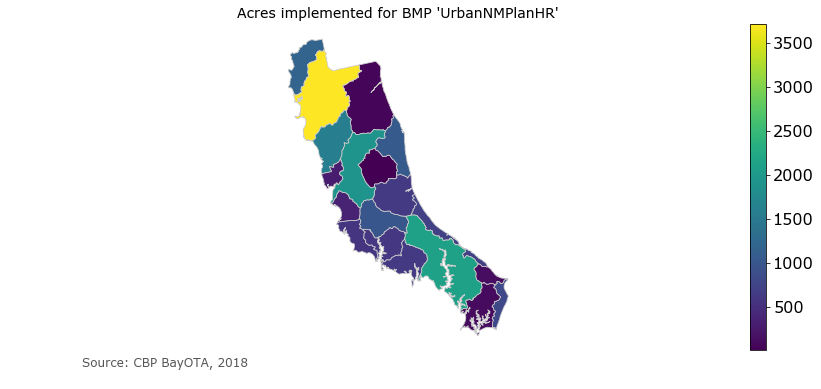

In [86]:
# from bayota_settings.config_script import get_graphics_dir

# set a variable that will call whatever column we want to visualise on the map
variable = 'acres'
# set the range for the choropleth
vmin, vmax = 0, mapdata_merged[variable].max()
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(14, 6))
lims = plt.axis('equal')

mapdata_merged.plot(column=variable, cmap='viridis', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
# other colormap ideas: Blues, viridis, cividis, plasma

# remove the axis
ax.axis('off')

# add a title
# titlestr = "Total cost for a 10% Total Nitrogen Reduction (from 2010 'No-action')"
titlestr = "Acres implemented for BMP 'UrbanNMPlanHR'"
ax.set_title(titlestr, fontdict={'fontsize': '14', 'fontweight' : '3'})

# create an annotation for the data source
ax.annotate("Source: CBP BayOTA, 2018",
            xy=(0.1, .08), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=12, color='#555555')

# Save the map
# fig.savefig("map_export_new.png",
#             bbox_inches='tight', dpi=300)
## fig.savefig(os.path.join(get_graphics_dir(), "map_export_new.png"),
##             bbox_inches='tight', dpi=300)